In [1]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.column_data import *
import torch.nn as nn

Generate synthetic data of x1^2 + x2^2 function with random noise

In [2]:
input_range = np.arange(-1,1,.05)
x1,x2 = np.meshgrid(input_range, input_range) 
x1 = x1.reshape([-1,1])
x2 = x2.reshape([-1,1])
X =np.concatenate([x1,x2], axis=1)
Y = x1 * x1 + x2 * x2 + np.random.normal(.1)

Take out random 20% for validation set

In [3]:
shuff = np.random.permutation(len(X))
train_size = int(len(X) * 0.8)
train_idx = shuff[:train_size]
val_idx = shuff[train_size:]
trainX, trainY, valX, valY = X[train_idx], Y[train_idx], X[val_idx], Y[val_idx]


Use ArraysIndexDataset put arrays into datasets and create ModelData out of it

In [4]:
train_aid = ArraysIndexDataset(trainX, trainY, None)
val_aid = ArraysIndexDataset(valX, valY, None)
md = ModelData.from_dls('.', DataLoader(train_aid,batch_size=16), DataLoader(val_aid,batch_size=16))

Tiny neural net pytorch model (no .cuda() so I can run it on CPU)

In [5]:
mininet = nn.Sequential(
    nn.Linear(2, 10),
    nn.ReLU(),
    nn.Linear(10, 10),
    nn.ReLU(),
    nn.Linear(10, 1),
)

Create Learner for my model, need to wrap it in fastai BasicModel.
This allows me to use the learning rate finder

  0%|          | 0/80 [00:00<?, ?it/s]


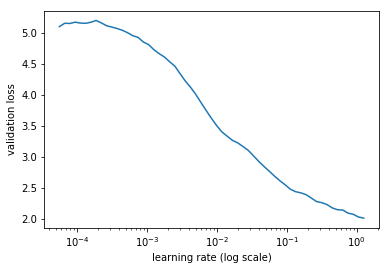

In [6]:
learn = Learner(md,BasicModel(mininet),crit=nn.MSELoss())
learn.lr_find()
learn.sched.plot()

And finally train with cyclical learning rate.

In [7]:
learn.fit(1e-2,3,cycle_len=2, cycle_mult=2)

epoch      trn_loss   val_loss        
    0      0.522018   0.154176  
    1      0.202892   0.135903        
    2      0.106134   0.052498        
    3      0.044772   0.024611        
    4      0.023902   0.019703        
    5      0.0185     0.019254        
    6      0.015372   0.015297        
    7      0.012699   0.012472        
    8      0.010711   0.010909        
    9      0.009289   0.009893        
    10     0.008443   0.009093        
    11     0.007955   0.008642        
    12     0.007693   0.008548        
    13     0.007584   0.008538        



[array([0.00854])]

In [8]:
preds = mininet(V(valX)).data.cpu().numpy()
mse = ((preds-valY)**2).mean()
mse

0.008537675789061524